<a href="https://colab.research.google.com/github/PretiElvina/Studi-Independen/blob/main/Tugas%20Studi%20Independen/Introduction_to_DS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediksi Karyawan Resign

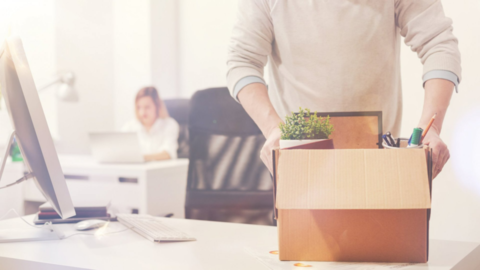

[Sumber](https://www.inc.com/scott-mautz/11-toxic-avoidable-reasons-your-best-employees-quit.html)

Kamu adalah seorang AI Engineer yang memiliki client seorang pemilik perusahaan di badang jasa.

Suatu hari, kamu diminta oleh sang client untuk mengembangkan sebuah aplikasi yang bisa membantunya menekan jumlah karyawan resign. Berikut adalah problem statement yang telah kamu gali untuk kasus kali ini:

> Pemilik perusahaan punya masalah terkait banyaknya jumlah karyawan resign saat memasuki pertengahan tahun.
>
> Solusi idealnya adalah mengembangkan sebuah aplikasi AI yang dapat memprediksi apakah seorang karyawan akan resign atau tidak berdasarkan data karyawan.
>
> Jika pemilik perusahaan mengetahui lebih awal siapa karyawan yang akan resign, maka ia dapat mengatur strategi untuk tetap mempertahankan karyawan tersebut.



In [ ]:
# import library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# split train set dan test set
from sklearn.model_selection import train_test_split

# standardization
from sklearn.preprocessing import StandardScaler

# mencari model dengan setting-an hyperparameter terbaik
from sklearn.model_selection import GridSearchCV

# model Decision Tree
from sklearn.tree import DecisionTreeClassifier

# menilai performa model
from sklearn.metrics import classification_report

# visualisasi untuk model Decision Tree
from sklearn import tree

# save model untuk deploy
import joblib
import pickle

# library untuk mengabaikan pesan warning
import warnings
warnings.filterwarnings("ignore")

# 1. Load Dataset

Pertama, load dataset karyawan yang telah disediakan oleh divisi HR.
Download dataset di [sini](https://drive.google.com/file/d/1f5fxGrsO6T7Ge3qgmvgN0moy-kxujUuD/view?usp=sharing).

In [ ]:
df = pd.read_csv('Dataset_HR.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'Dataset_HR.csv'


Analisis tiap kolom yang ada di dalam dataset, kemudian tentukan feature dan label.

Karena kita ingin memprediksi karyawan yang akan resign, maka kita pilih kolom **resign** sebagai label. Sementara, kolom sisanya menjadi feature.

Selanjutnya, pindahkan label (kolom resign) ke posisi ujung sebelah kanan table, untuk memudahkan kita pada proses selanjutnya.


In [ ]:
temporary = df['resign']
df.drop(labels=['resign'], axis=1, inplace = True)
df['resign'] = temporary # pindahkan label ke posisi ujung sebelah kanan
df.head()

In [ ]:
# ukuran dataset yang kita miliki
df.shape

Pastikan tidak ada missing dan duplicate value dalam dataset sebelum kita ke tahap berikutnya.



In [ ]:
# periksa missing value
df.isnull().sum()

In [ ]:
# periksa duplicate value
df.duplicated().sum()

Jika ditemukan missing dan duplicate value, maka kita harus melakukan *data preprocessing* terlebih dahulu.

Kabar baiknya, dataset kita tidak memiliki missing ataupun duplicate value sehingga kita bisa ke tahap berikutnya.

>**Note**: jangan khawatir, materi tentang data preprocessing akan tetap kita bahas pada pertemuan selanjutnya.

# 2. Data Preparation

Dalam dataset kita, masih terdapat kolom yang memiliki nilai kategorik, yakni kolom:
- kecelakaan_kerja
- promosi
- divisi
- gaji, dan
- resign

Sayangnya, library Machine Learning hanya bisa memproses data numerik. Supaya dataset kita bisa diproses library Machine Learning, kita perlu mengubah kolom bernilai kategorik menjadi numerik.


Salah satu metode yang bisa kita gunakan untuk mengubah nilai suatu kolom adalah Label Encoding.

In [ ]:
# label encoding kolom kecelakaan_kerja
df['kecelakaan_kerja'] = df['kecelakaan_kerja'].map({'tidak':0, 'pernah':1})

# label encoding kolom promosi
df['promosi'] = df['promosi'].map({'tidak':0, 'ya':1})

# label encoding kolom divisi
df['divisi'] = df['divisi'].map({'sales':0,
                               'accounting':1,
                               'hr':2,
                               'technical':3,
                               'support':4,
                               'management':5,
                               'IT':6,
                               'product_mng':7,
                               'marketing':8,
                               'RandD':9})

# label encoding kolom gaji
df['gaji'] = df['gaji'].map({'low':0, 'medium':1, 'high':2})

# label encoding kolom resign
df['resign'] = df['resign'].map({'tidak':0, 'ya':1})

In [ ]:
df.head()

Dataset kita memiliki 11.991 baris (observasi) dan 9 buah feature dan. Feature yang terlalu banyak dan observasi yang terlalu sedikit dapat menyebabkan performa model menurun.

Solusi masalah ini adalah dengan mereduksi feature dalam dataset, atau biasa disebut dengan *Dimensionality Reduction*.

> **Note**: *Dimensionality Reduction* akan kita bahas pada pertemuan berikutnya

Salah satu metode *dimensionality reductio*n adalah dengan memilih feature yang paling berkorelasi dengan label menggunakan heatmap. Kita akan memilih 5 feature berdasarkan label resign.

In [ ]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

Lima feature dengan nilai korelasi terbesar, **baik positif atau negatif**, terhadap label resign adalah:

1. tingkat_kepuasan (-0.35)
2. lama_bekerja (0.17)
3. kecelakaan_kerja (-0.13)
4. gaji (-0.099)
5. jam_kerja_perbulan (0.07)

Selanjutnya, kita hanya menggunakan 5 feature ini pada tahap modeling.


Pisahkan feature dan label. Simpan nilai feature ke dalam variable **X** dan nilai label ke dalam variable **y**.

In [ ]:
nama_feature = ['tingkat_kepuasan', 'lama_bekerja', 'kecelakaan_kerja', 'gaji', 'jam_kerja_perbulan']

X = df[nama_feature].values
y = df['resign'].values

Pisahkan dataset menjadi training set (80%) dan test set (20%) menggunakan **[traintestsplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)**.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Modeling

Banyak sekali algoritma klasifikasi Machine Learning yang bisa kita implementasikan pada model kita. Namun tidak semua algoritma tersebut cocok dengan dataset.

Dataset_HR termasuk dataset yang tidak seimbang (imbalanced dataset).
- Label 0 memiliki jumlah observasi sebanyak 10.000.
- Sedangkan, label 1 memiliki jumlah observasi sebanyak 1991.

Salah satu algoritma yang cocok untuk imbalanced dataset adalah **Decision Tree**. Kita akan mengimplementasikan algoritma ini pada model kita.

In [ ]:
# jumlah observasi pada tiap label
df.resign.value_counts()

Coba kalian perhatikan kelima feature secara seksama. Feature-feature tersebut memiliki rentang nilai yang cukup jauh satu sama lain. Contohnya seperti, feature **tingkat_kepuasan** memiliki rentang nilai desimal, sedangkan feature **jam_kerja_perbulan** memiliki rentang nilai ratusan.


Jika kita memilih algoritma klasifikasi lainnya, seperti SVM dan ANN. Kita perlu men-scale nilai feature. Namun, kita tidak perlu melakukan hal tersebut pada algoritma Decision Tree. [Sumber](https://www.scaler.com/topics/decision-tree-algorithm/#advantages-and-disadvantages).

> **Note**: kita akan tetap men-scale nilai feature dengan alasan pembelajaran menggunakan [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

In [ ]:
df.head()

Scale feature (X_train dan X_test) menggunakan module StandardScaler.


Kita bisa saja menormalisasi feature menggunakan MinMaxScaler. Hanya saja, MinMaxScaler lebih cocok untuk feature yang rentang nilainya sudah kita ketahui secara pasti. Contohnya seperti pixel pada image, yang selalu memiliki rentang nilai 0 sampai dengan 255.


Simpan feature yang sudah discale dalam variable X_train_scaled dan X_test_scaled.

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

# hasil scale 5 baris teratas
print(X_train_scaled[:5, :])

Setelah feature dan label siap, langkah selanjutnya adalah melatih model-model.

Sebagai seorang AI Engineer yang baik, kita tidak hanya melatih satu model saja. Kita akan melatih banyak model dengan berbagai macam algoritma dan setting-an hyperparameter.

Pada kasus ini, kita hanya akan melatih model menggunakan algoritma Decision Tree. Meskipun hanya 1 algoritma, kita akan tetap melatih lebih dari satu model Decision Tree dengan setting-an hyperparameter yang berbeda-beda, menggunakan [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).


Settingan hyperparameter yang akan kita gunakan:
- max_depth = 2, 3, 4, 5, 6, 7, 8, dan 9
- max_leaf_nodes = 2, 3, 4, 5, 6, 7, 8, dan 9

Total jumlah model yang kita latih adalah 64 model Decision Tree.

In [ ]:
# model Decision Tree
test_model = DecisionTreeClassifier(random_state=42)

# hyperparameter
params = {'max_depth': list(range(2, 10)),
          'max_leaf_nodes': list(range(2, 10))}

search_best_model = GridSearchCV(test_model, params, cv=20)

# training model
search_best_model.fit(X_train_scaled, y_train)

In [ ]:
# model dengan hyperparameter terbaik
search_best_model.best_estimator_

Dari total 64 model Decision Tree yang kita train, kita hanya akan memilih satu model dengan performa terbaik.

Model tersebut memiliki setting-an hyperparameter **max_depth=5** dan **max_leaf_nodes=9**.

# 4. Evaluation

Setelah mendapat model Decision Tree terbaik, langkah berikutnya adalah melakukan re-modeling dan mengevaluasi performa model menggunakan [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

In [ ]:
# melakukan re-modeling (menyimpan model terbaik dalam variable model)
model = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, random_state=42)
model.fit(X_train_scaled, y_train)

In [ ]:
# mengevaluasi model
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

Hasil evaluasi model menunjukkan bahwa model kita memiliki:
- precision 97%
- recall 97%
- accuracy 97%

> **Note**: karena model kita memiliki jumlah label yang tidak seimbang (imbalanced data), maka kita menggunakan **weighted avg**.


Berdasarkan hasil evaluasi, model kita telah siap untuk dideploy karena sudah memiliki performa yang baik.

Salah satu kelebihan model Decision Tree adalah kita dapat melihat diagram tree yang dihasilkan oleh model. Diagram tree ini digunakan untuk memprediksi apakah seorang karyawan akan resign atau tidak berdasarkan data karyawan tersebut.

> **Note**: nilai diagram tree tidak sesuai dengan nilai dataset dikarenakan proses standardization feature yang kita lakukan.

In [ ]:
plt.figure(figsize=(25,20))
tree.plot_tree(model,
               feature_names = nama_feature,
               class_names = ['tidak', 'iya'],
               filled = True)
plt.show()

Lakukan prediksi data baru menggunakan model tersebut.

In [ ]:
# input data baru
lama_bekerja = 3#@param {type:"number"}
jam_kerja_per_bulan = 157#@param {type:"number"}
kecelakaan_kerja = 0 #@param [0, 1]{type:"raw"}
gaji = 0 #@param [0, 1, 2]{type:"raw"}
tingkat_kepuasan = 37 #@param {type:"slider", min:0, max:100, step:1}

tingkat_kepuasan = tingkat_kepuasan/100

# data baru yang diinput harus di-standardization terlebih dahulu
data_baru = [[tingkat_kepuasan, lama_bekerja, kecelakaan_kerja, gaji, jam_kerja_per_bulan]]
data_baru = scaler.transform(data_baru)

# prediksi data baru, yang sudah di-standardization, menggunakan model Decision Tree terbaik
hasil_prediksi = model.predict(data_baru)
hasil_prediksi = int(hasil_prediksi)

# probabilitas prediksi
nilai_kepercayaan = model.predict_proba(data_baru).flatten()
nilai_kepercayaan = max(nilai_kepercayaan) * 100
nilai_kepercayaan = round(nilai_kepercayaan)

# hasil prediksi
print(f'Karyawan tersebut diprediksi {nilai_kepercayaan}% ', end='')
if hasil_prediksi == 0:
  print('tidak resign!')
elif hasil_prediksi == 1:
  print('akan resign!')

# Save Model

Langkah terakhir adalah men-save model dan scaler object (standardization function) dalam file pickle.

Kita membutuhkan file-file pickle ini pada tahap deployment.

In [ ]:
pickle.dump(scaler, open('scaler_ds.pkl', 'wb'))
pickle.dump(model, open('model_ds.pkl', 'wb'))

**Note**: Jangan lupa download file-file ini melalui side menu Colab (jika kalian memakai Colab).